In [1]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil

plt.style.use('ggplot')

In [2]:
with open("../credenciales.json", 'r') as f:
    conn_data = json.load(f)

DB_CONN = f'mysql+mysqlconnector://{conn_data["username"]}:{conn_data["password"]}@{conn_data["host"]}/{conn_data["database"]}'

## cogiendo toda la base de datos


### carga de datos

se realiza inicialmente descripcion individual de las variables

las siguientes variables de la tabla `accountdata` no se tuvieron en cuenta:

| variable | razon |
|-----------|-----------|
| Username          | inicialmente no se ve que aporten a la clasificacion |
| Email             | inicialmente no se ve que aporten a la clasificacion |
| Armour            | inicialmente no se ve que aporten a la clasificacion |
| Health            | inicialmente no se ve que aporten a la clasificacion |
| x, y, z           | inicialmente no se ve que aporten a la clasificacion |
| Weapons           | inicialmente no se ve que aporten a la clasificacion |
| LastSerial        | inicialmente no se ve que aporten a la clasificacion |
| LastIP            | inicialmente no se ve que aporten a la clasificacion |
| weapstats         | inicialmente no se ve que aporten a la clasificacion |
| items             | inicialmente no se ve que aporten a la clasificacion |
| plrtosrvrsettings | inicialmente no se ve que aporten a la clasificacion |
| purgapoints | solo contiene valores de 0 |
| experiencia | solo contiene 2 valores distintos (0 y 150), se sospecha que no esta en uso |  
| JobRank | contiene demasiadas subclases y es dificil establecer una jerarquia entre ellas |
| GroupName | demasidas clases y dificl establecer jerarquia entre ellas |
| GroupRank | demasidas clases y dificl establecer jerarquia entre ellas |
| UnenployedSkin | no se tiene informacion relevante, solo son los ids de las skins |
| Skin | no se tiene informacion relevante, solo son los ids de las skins |

In [3]:
SQL = """ 
SELECT 
    ad.Money,
    ad.Interior,
    ad.Dimension,
    ad.Team,
    ad.Job,
    ad.Playtime_mins,
    ad.JailTime,
    ad.WL,
    DATEDIFF(CURDATE(), ad.LastOnline) AS DaysSinceLastOnline,
    ad.Kills,
    ad.Deaths,
    ad.Drift_Points,

    COALESCE(ba.Balance, 0) AS Bank_money,

    ad.vip
FROM accountdata ad
LEFT JOIN bank_accounts ba ON ad.Username = ba.Account
"""

df = pd.read_sql(SQL, DB_CONN)

df["vip"] = df["vip"].map(lambda x: False if x in ["None", "false"] else True)

### Preprocematientos

In [4]:
# PREPROCESAMIENTOS
df.drop_duplicates(inplace=True)

# convertir variables string a minusculas
str_cols = df.select_dtypes(include="object").columns
df[str_cols] = df[str_cols].apply(lambda x: x.str.lower())

# filtrar y convertir variables Team y Job a "tiene Team" y "tiene Job" respectivamente 
# (se hace esto debido a que es dificil establecer una jerarquia en estas variables)
df = df[~df["Team"].isin(["nameless", "2cb", "frutiã±o"])]
df = df[~df["Job"].isin(["0", "banned"])]

df["Team"] = df["Team"].map(lambda x: True if x != "unemployed" else False)
df["Job"] = df["Job"].map(lambda x: True if x not in ["unemployed", "none"] else False)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 62386 entries, 0 to 62392
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Money                62386 non-null  int64
 1   Interior             62386 non-null  int64
 2   Dimension            62386 non-null  int64
 3   Team                 62386 non-null  bool 
 4   Job                  62386 non-null  bool 
 5   Playtime_mins        62386 non-null  int64
 6   JailTime             62386 non-null  int64
 7   WL                   62386 non-null  int64
 8   DaysSinceLastOnline  62386 non-null  int64
 9   Kills                62386 non-null  int64
 10  Deaths               62386 non-null  int64
 11  Drift_Points         62386 non-null  int64
 12  Bank_money           62386 non-null  int64
 13  vip                  62386 non-null  bool 
dtypes: bool(3), int64(11)
memory usage: 5.9 MB


### analisis descriptivo de las variables

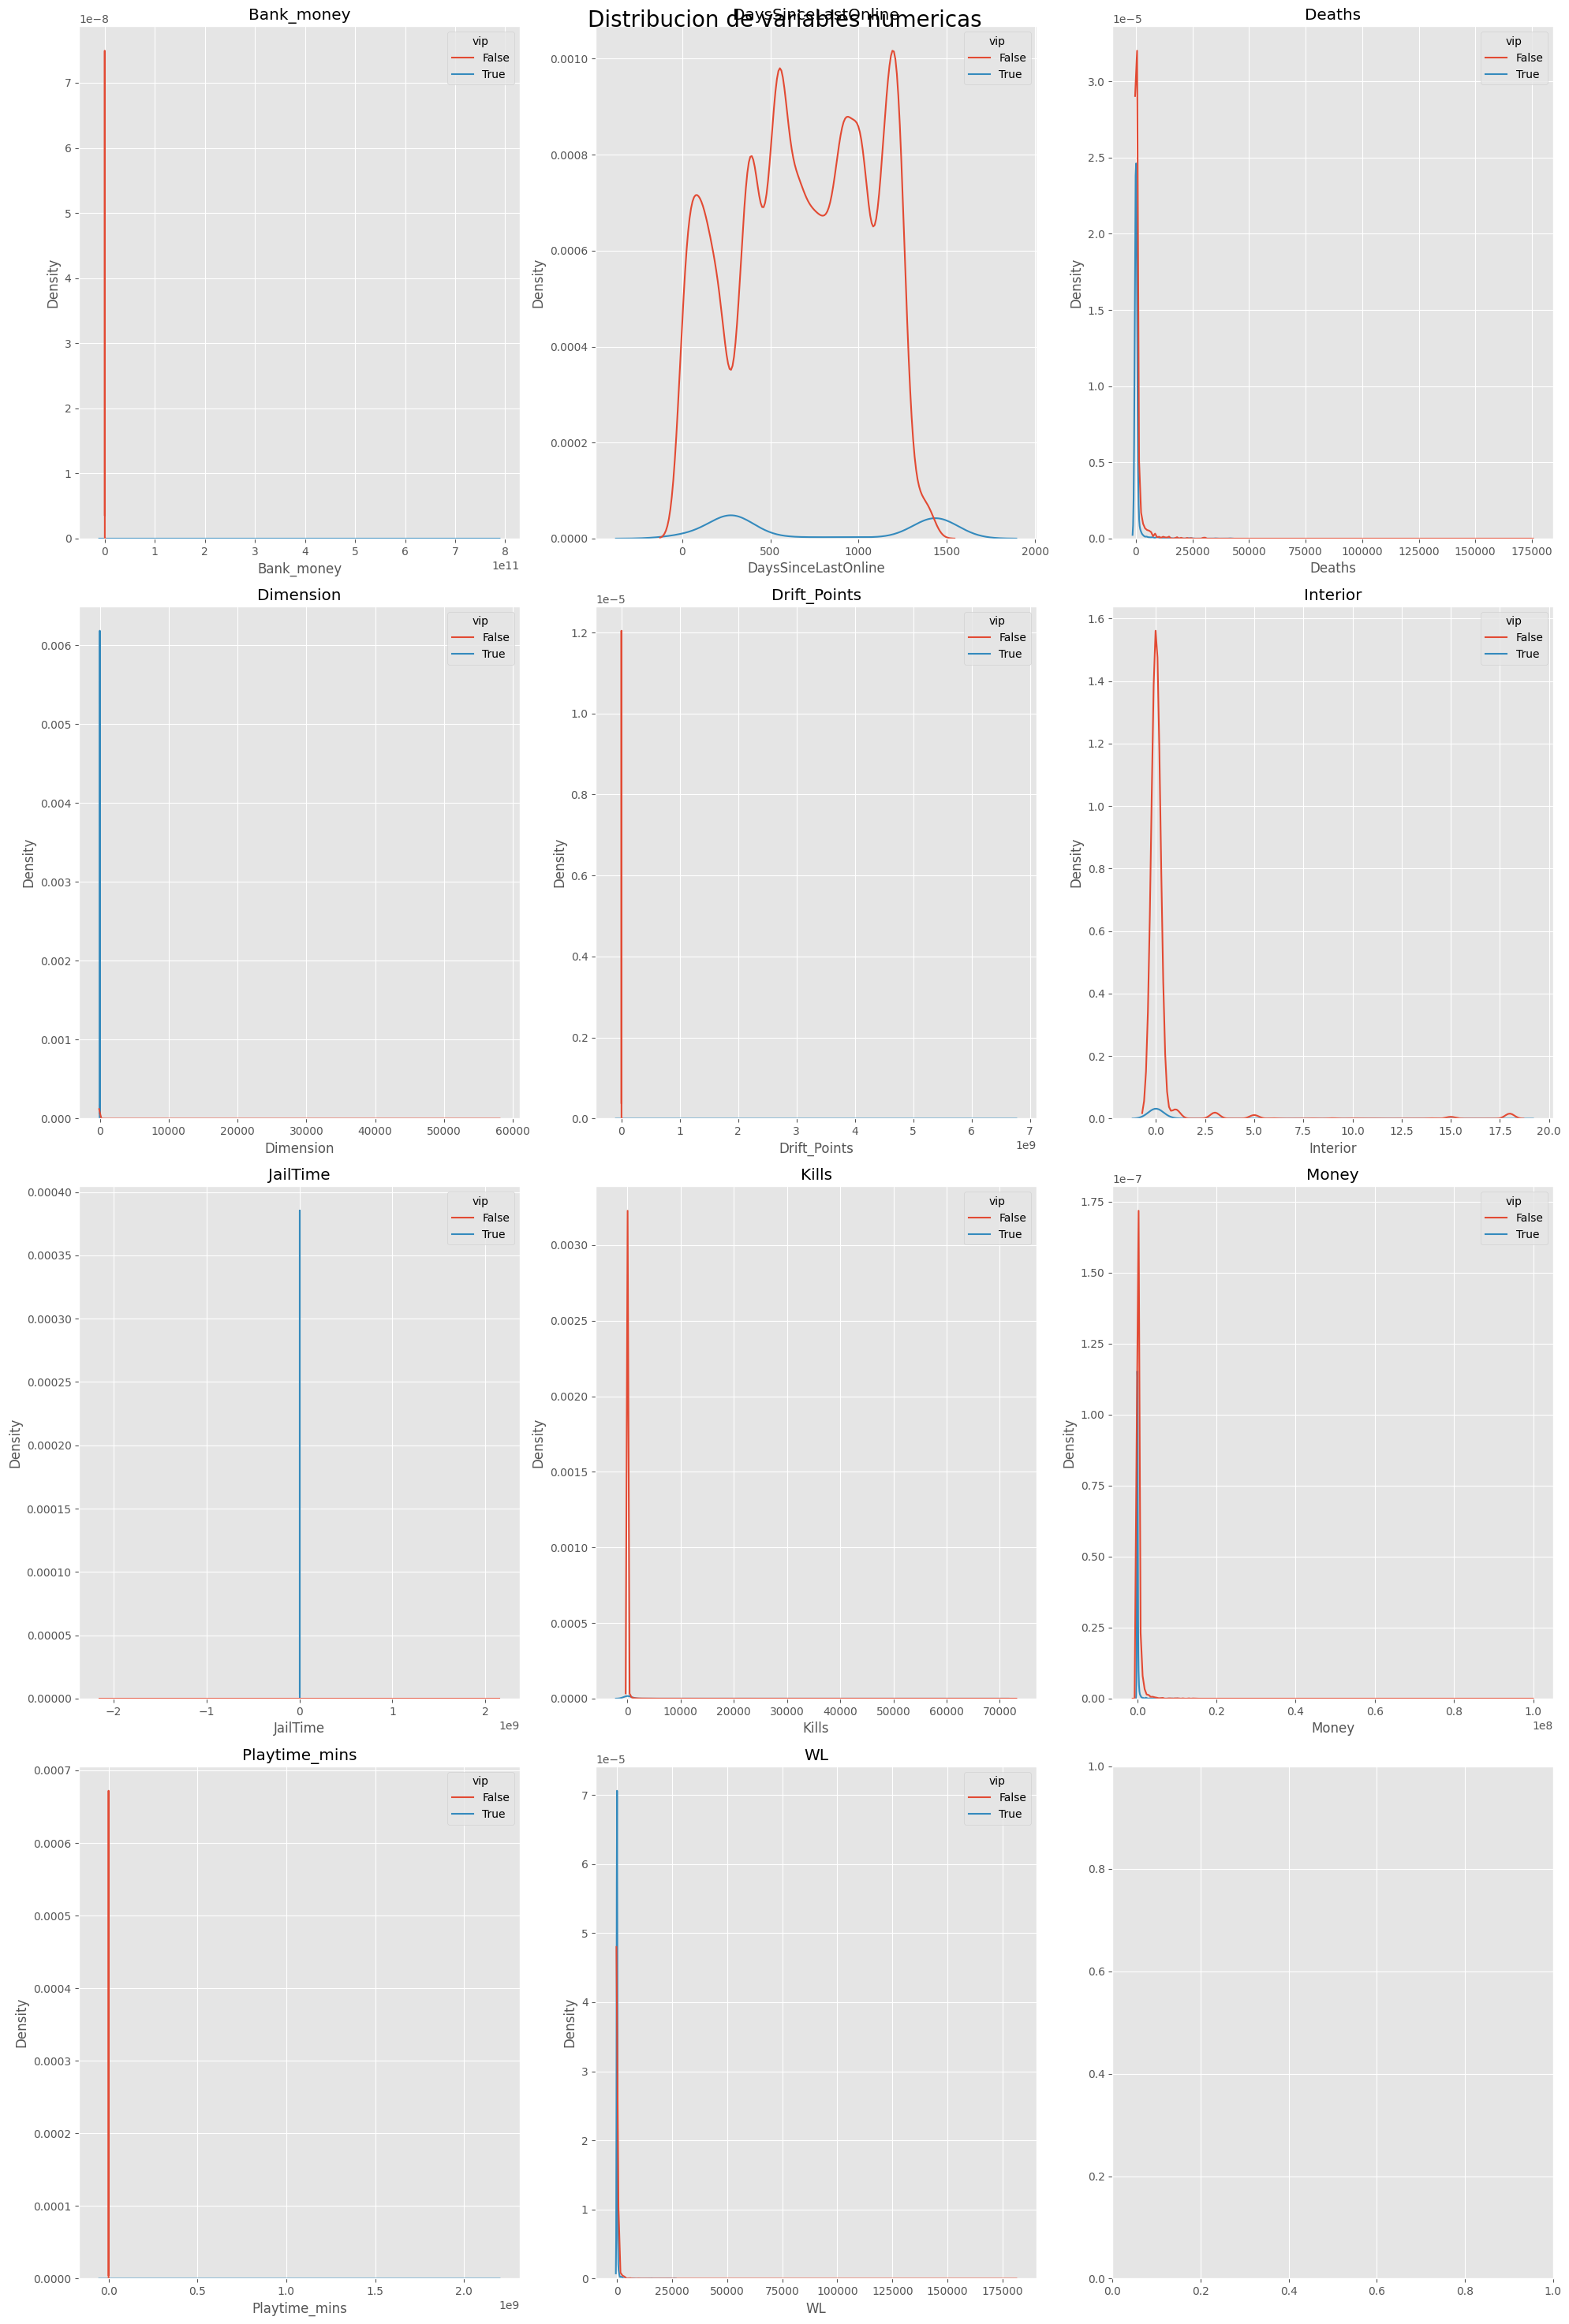

In [6]:
num_cols = df.select_dtypes(include=np.number).columns

num_cols = num_cols.difference(["vip"])

_, axes = plt.subplots(ceil(num_cols.size/3), 3, figsize=(20, 30))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    sns.kdeplot(df, x=col, hue="vip", ax=axes[i])

    axes[i].set_title(col)

plt.suptitle("Distribucion de variables numericas", fontsize=20)
plt.tight_layout()
plt.show()

se observa que existen valores muy atipicos.

se ve claramente que algunas variables como "Bank_money", "Drift_Points", "JailTime", "Playtime_mins" distinguen muy bien los que han comprado VIP y los que no. sin embargo puede que los valores atipicos afecten este analisis

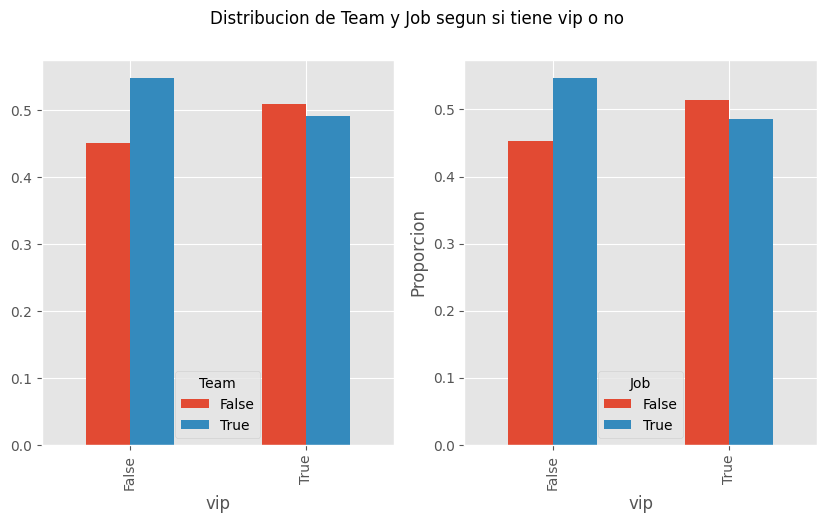

In [7]:
_, axes = plt.subplots(1, 2, figsize=(10,5))

cat_cols = ["Team", "Job"]
for i, col in enumerate(cat_cols):
    df[[col, "vip"]].pivot_table(
        index="vip",
        columns=col,
        aggfunc="size"
    ).apply(lambda x: x/x.sum(), axis=1).plot.bar(ax=axes[i])

plt.suptitle("Distribucion de Team y Job segun si tiene vip o no")
plt.ylabel("Proporcion")
plt.show()

Solo se oberva que levemente los que no tienen VIP suelen tener Team y Job

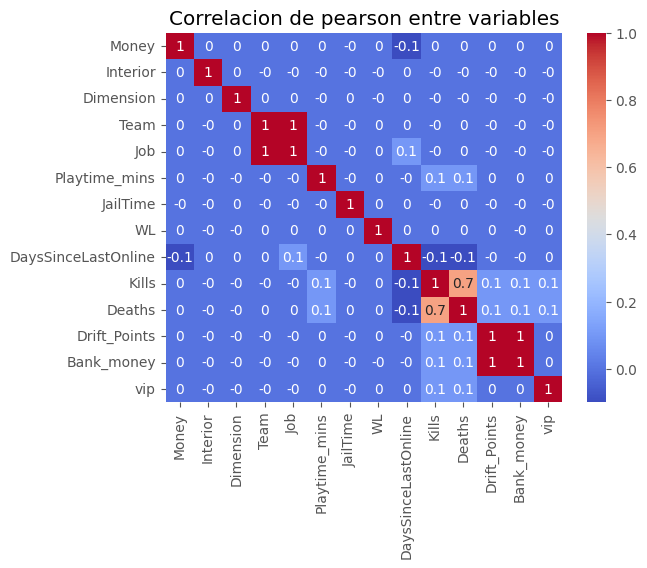

In [8]:
sns.heatmap(df.corr().round(1), annot=True, cmap="coolwarm")

plt.title("Correlacion de pearson entre variables")
plt.show()

In [9]:
def cramers_V(df):
    def get_cramersV_corr(var1, var2):
        from scipy.stats import chi2_contingency
        crosstab = np.array(pd.crosstab(var1, var2, rownames=None, colnames=None))
        stat = chi2_contingency(crosstab)[0]
        obs = np.sum(crosstab)
        mini = min(crosstab.shape) - 1
        return (stat/(obs*mini))


    rows= []
    for var1 in df.columns:
        col = []
        for var2 in df.columns:
            cramers = get_cramersV_corr(df[var1], df[var2])
            col.append(round(cramers,2))
        rows.append(col)

    return pd.DataFrame(rows, columns=df.columns, index=df.columns)


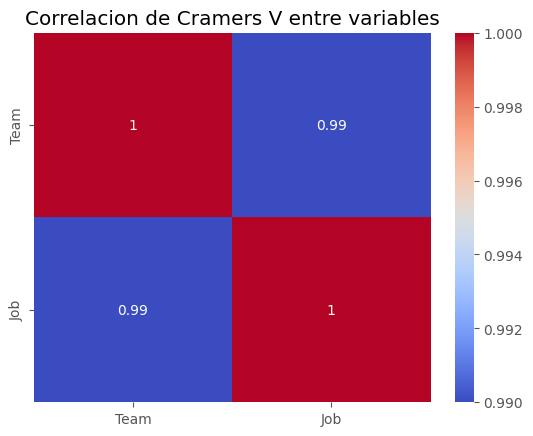

In [10]:
sns.heatmap(cramers_V(df[["Team", "Job"]]), annot=True, cmap="coolwarm")

plt.title("Correlacion de Cramers V entre variables")
plt.show()

de las matrices de correlacion se concluye que:
- la mayoria de variables no estan correlacionadas entre si
- existen variables como Job, Team, Kills, Deaths, Bank_Money y Drift_Points, que tienen correlaciones muy altas por lo que se tomaran como redundantes

## cogiendo jugadores activos de los ultimos 6 meses

### carga de datos

In [11]:
SQL = """ 
SELECT 
    ad.Money,
    ad.Interior,
    ad.Dimension,
    ad.Team,
    ad.Job,
    ad.Playtime_mins,
    ad.JailTime,
    ad.WL,
    DATEDIFF(CURDATE(), ad.LastOnline) AS DaysSinceLastOnline,
    ad.Kills,
    ad.Deaths,
    ad.Drift_Points,

    COALESCE(ba.Balance, 0) AS Bank_money,

    ad.vip
FROM accountdata ad
LEFT JOIN bank_accounts ba ON ad.Username = ba.Account

WHERE ad.LastOnline > '2023-05-01'
"""

df = pd.read_sql(SQL, DB_CONN)

df["vip"] = df["vip"].map(lambda x: False if x in ["None", "false"] else True)

### Preprocesamientos

In [12]:
# PREPROCESAMIENTOS

# convertir variables string a minusculas
str_cols = df.select_dtypes(include="object").columns
df[str_cols] = df[str_cols].apply(lambda x: x.str.lower())

# filtrar y convertir variables Team y Job a "tiene Team" y "tiene Job" respectivamente 
# (se hace esto debido a que es dificil establecer una jerarquia en estas variables)
df = df[~df["Team"].isin(["nameless", "2cb", "frutiã±o"])]
df = df[~df["Job"].isin(["0", "banned"])]

df["Team"] = df["Team"].map(lambda x: True if x != "unemployed" else False)
df["Job"] = df["Job"].map(lambda x: True if x not in ["unemployed", "none"] else False)

# eliminar valores negativos de JailTime
df = df.query("JailTime >= 0")

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9011 entries, 0 to 9011
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Money                9011 non-null   int64
 1   Interior             9011 non-null   int64
 2   Dimension            9011 non-null   int64
 3   Team                 9011 non-null   bool 
 4   Job                  9011 non-null   bool 
 5   Playtime_mins        9011 non-null   int64
 6   JailTime             9011 non-null   int64
 7   WL                   9011 non-null   int64
 8   DaysSinceLastOnline  9011 non-null   int64
 9   Kills                9011 non-null   int64
 10  Deaths               9011 non-null   int64
 11  Drift_Points         9011 non-null   int64
 12  Bank_money           9011 non-null   int64
 13  vip                  9011 non-null   bool 
dtypes: bool(3), int64(11)
memory usage: 871.2 KB


### analisis descriptivo de las variables

/tmp/ipykernel_69360/4206562767.py:9: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df, x=col, hue="vip", ax=axes[i])


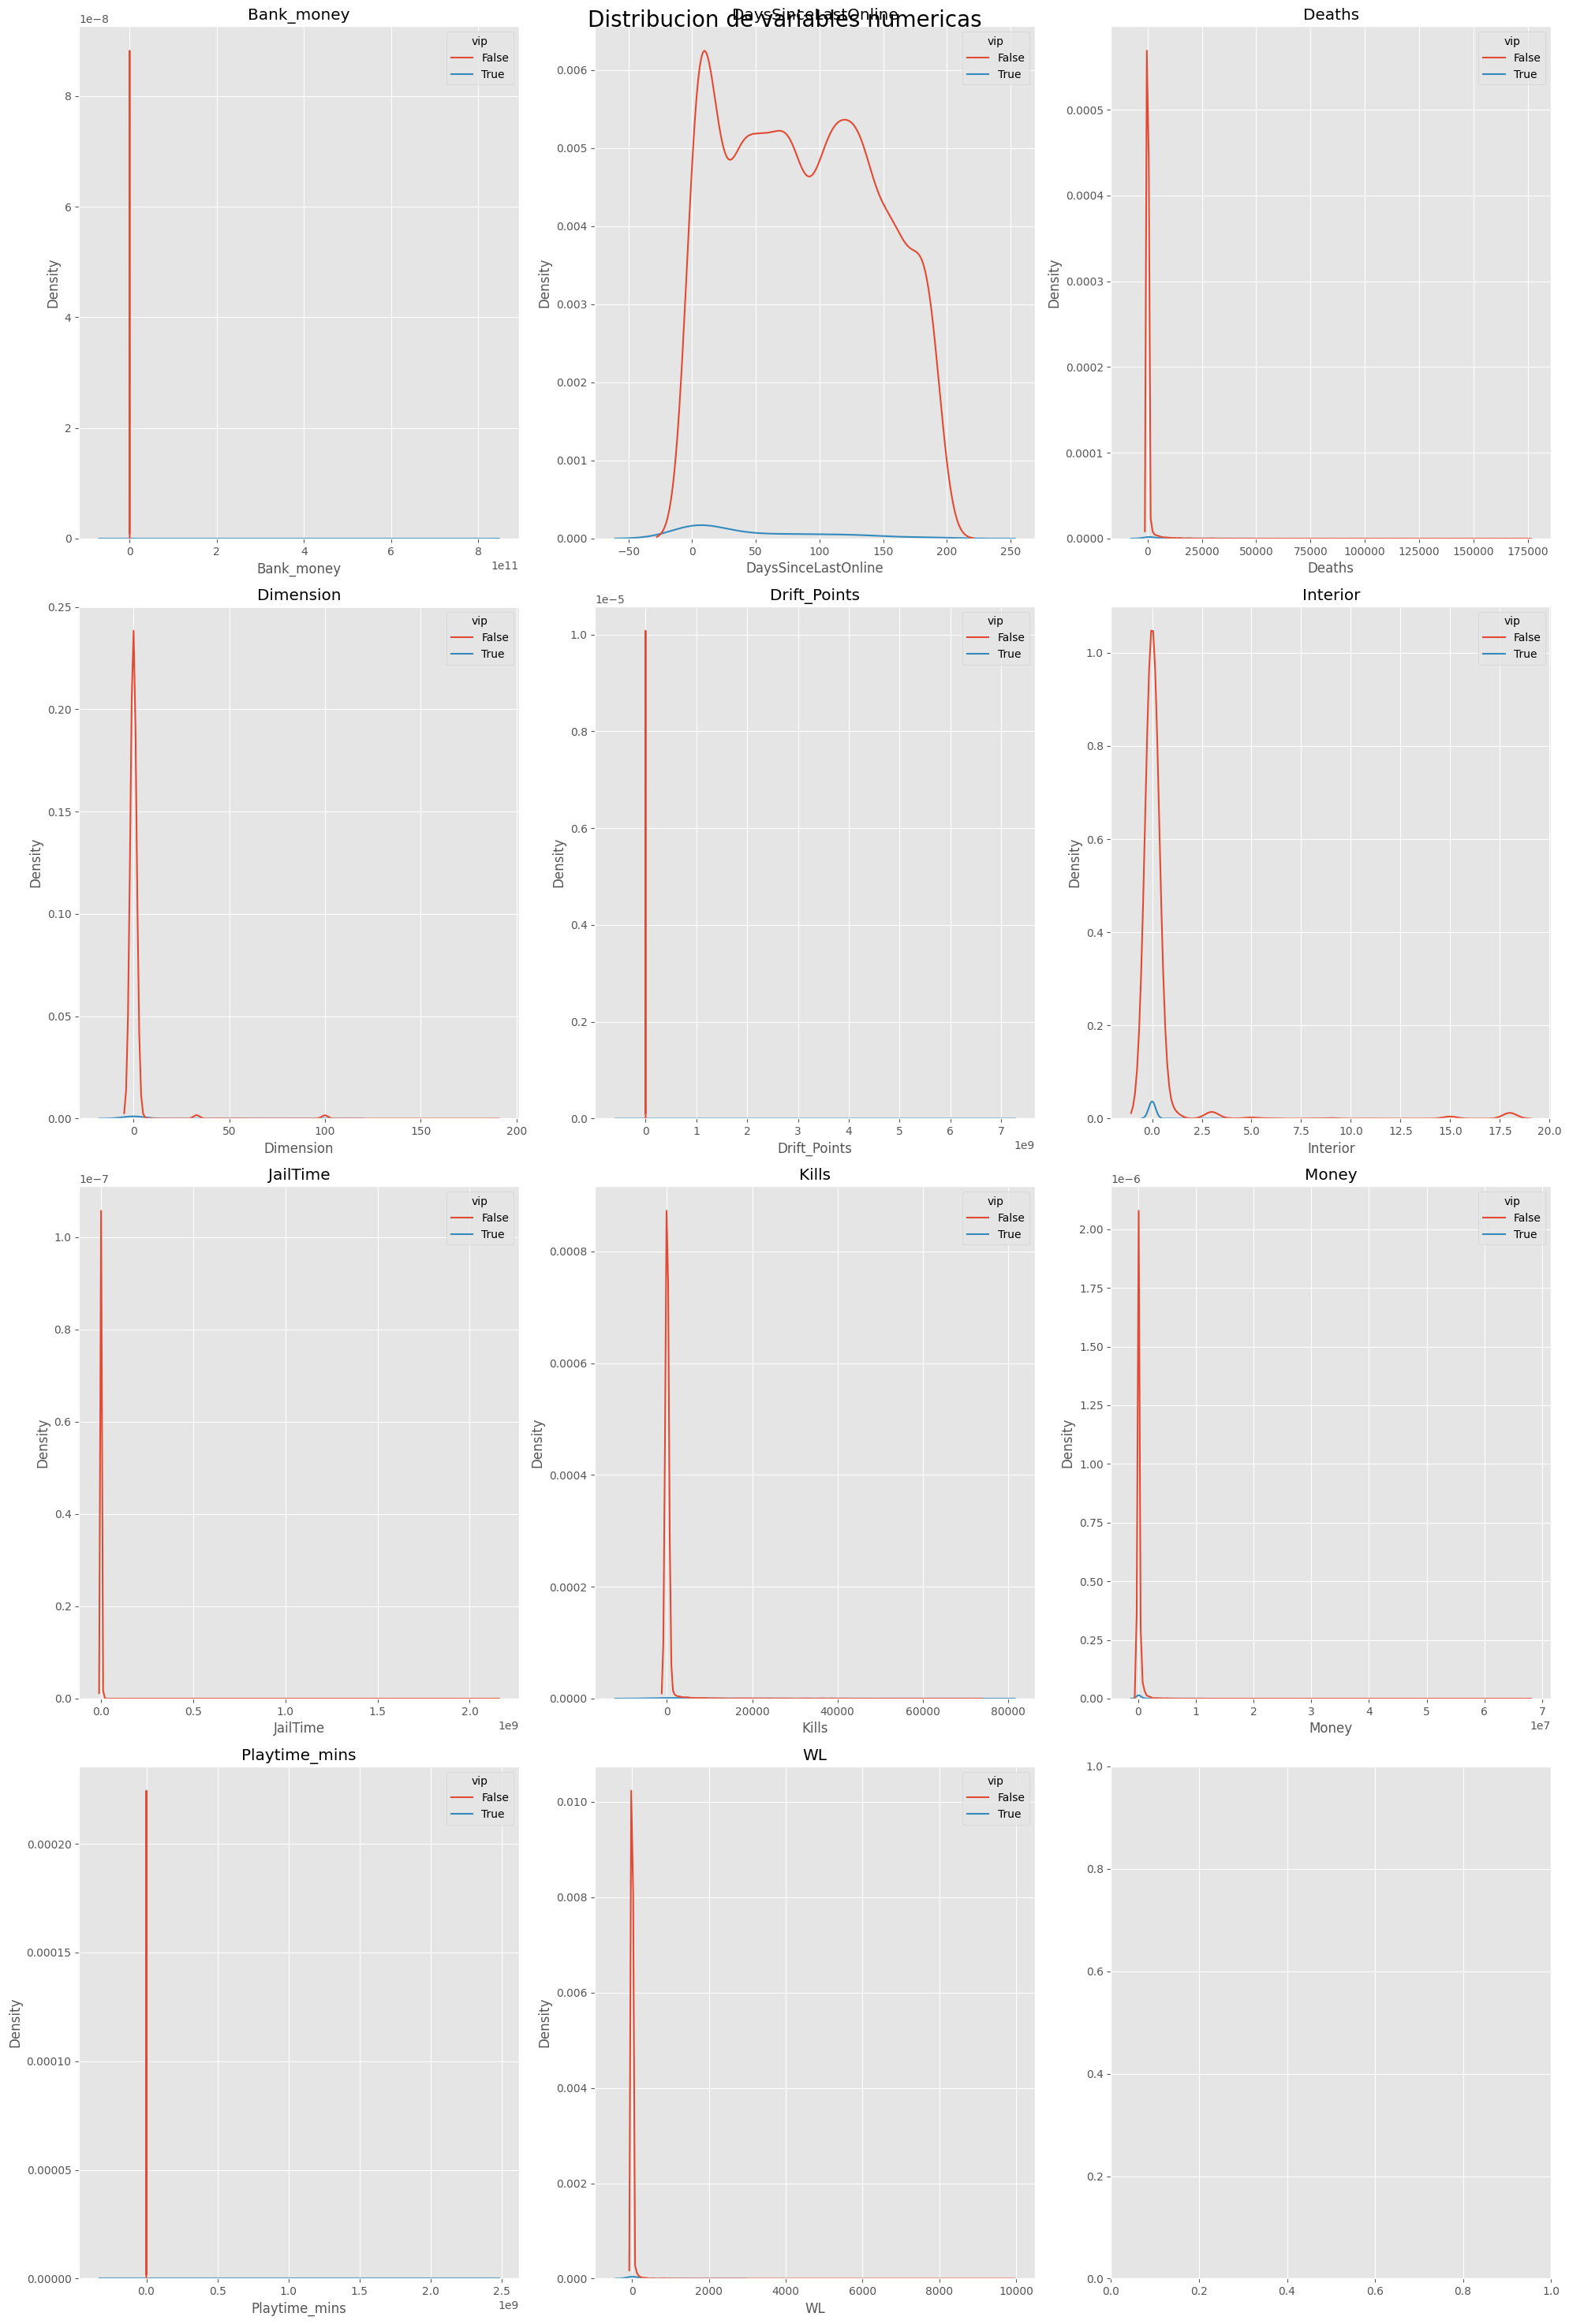

In [14]:
num_cols = df.select_dtypes(include=np.number).columns

num_cols = num_cols.difference(["vip"])

_, axes = plt.subplots(ceil(num_cols.size/3), 3, figsize=(20, 30))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    sns.kdeplot(df, x=col, hue="vip", ax=axes[i])

    axes[i].set_title(col)

plt.suptitle("Distribucion de variables numericas", fontsize=20)
plt.tight_layout()
plt.show()

In [15]:
df.groupby("vip").agg(["count", "mean", "std"]).round(2)

Money                        Interior             Dimension        \
      count       mean         std    count  mean   std     count  mean   
vip                                                                       
False  8861  176003.31   930635.64     8861  0.35  2.18      8861  1.18   
True    150  359977.97  1104295.75      150  0.06  0.48       150  2.69   

              Team  ...     Kills Deaths                   Drift_Points  \
         std count  ...       std  count     mean      std        count   
vip                 ...                                                   
False   9.85  8861  ...   2527.06   8861   320.80  2566.79         8861   
True   16.25   150  ...  11052.53    150  4103.38  6906.52          150   

                                 Bank_money                              
              mean           std      count          mean           std  
vip                                                                      
False     18230.84  2.194840e+05       8861  2.651547e+06  2.371294e+07  
True   45796586.13  5.446511e+08        150  5.319850e+09  6.349777e+10  

[2 rows x 39 columns]

se ven muchos valores atipicos, algunas variables como Bank_Money, Jailtime, playtime distinguen bien los que tienen VIP y los que no

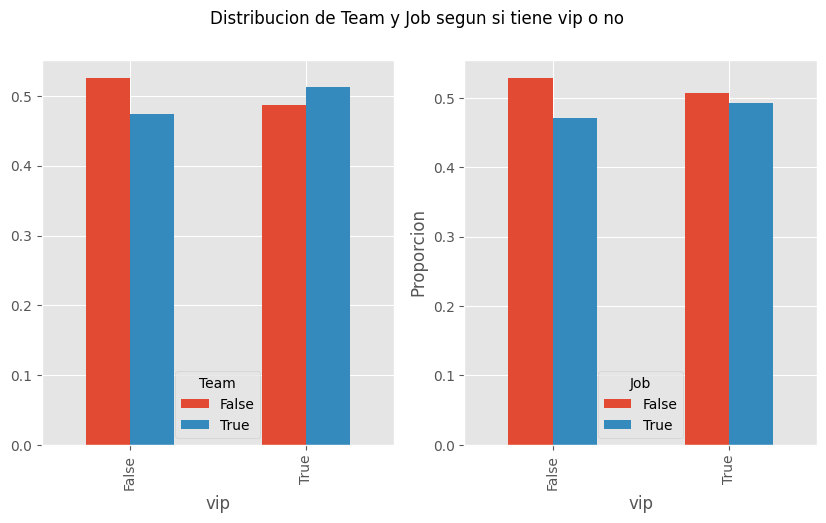

In [16]:
_, axes = plt.subplots(1, 2, figsize=(10,5))

cat_cols = ["Team", "Job"]
for i, col in enumerate(cat_cols):
    df[[col, "vip"]].pivot_table(
        index="vip",
        columns=col,
        aggfunc="size"
    ).apply(lambda x: x/x.sum(), axis=1).plot.bar(ax=axes[i])

plt.suptitle("Distribucion de Team y Job segun si tiene vip o no")
plt.ylabel("Proporcion")
plt.show()

no se nota mayor diferencia entre la distribucion de las variables Team y Job segun si tienen VIP o no

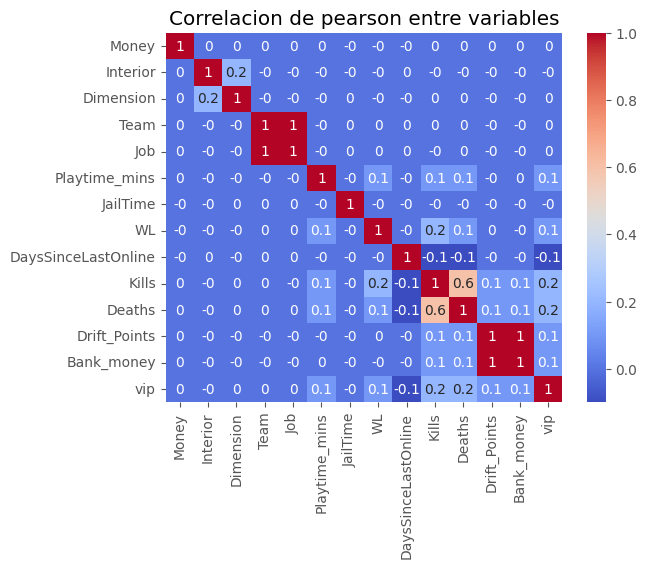

In [17]:
sns.heatmap(df.corr().round(1), annot=True, cmap="coolwarm")

plt.title("Correlacion de pearson entre variables")
plt.show()

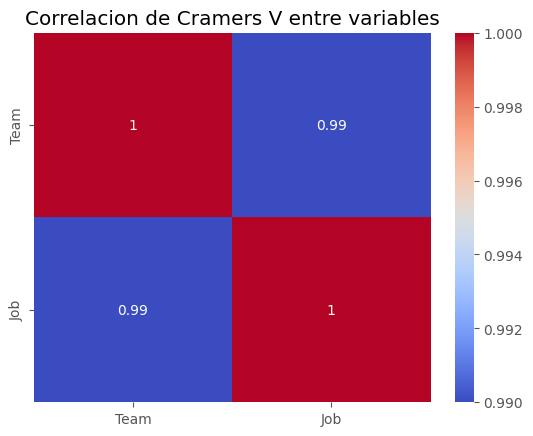

In [18]:
sns.heatmap(cramers_V(df[["Team", "Job"]]), annot=True, cmap="coolwarm")

plt.title("Correlacion de Cramers V entre variables")
plt.show()

se puede concluir lo mismo que tomando la base de datos completa